# Forecasting Tesla Stock Price

#### import packages

In [2]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import yfinance as yf
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series


## 1. Problem definition

### 1.1 Select a stock in the S&P 500

In [4]:
# Define stock ticker and date range
stock_ticker = 'TSLA' # Tesla stock
stock_start_date = datetime.date(2014,1,1)
stock_end_date = datetime.date.today()

# Fetch the stock price from Yahoo Finance using yfinance
stock_df = yf.download(stock_ticker, start=stock_start_date, end=stock_end_date)

[*********************100%***********************]  1 of 1 completed


In [5]:
stock_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,9.986667,10.165333,9.770000,10.006667,10.006667,92826000
2014-01-03,10.000000,10.146000,9.906667,9.970667,9.970667,70425000
2014-01-06,10.000000,10.026667,9.682667,9.800000,9.800000,80416500
2014-01-07,9.841333,10.026667,9.683333,9.957333,9.957333,75511500
2014-01-08,9.923333,10.246667,9.917333,10.085333,10.085333,92448000
...,...,...,...,...,...,...
2024-09-06,232.600006,233.600006,210.509995,210.729996,210.729996,112177000
2024-09-09,216.199997,219.869995,213.669998,216.270004,216.270004,67443500
2024-09-10,220.070007,226.399994,218.639999,226.169998,226.169998,78891100


In [6]:
stock_df.index

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2024-08-29', '2024-08-30', '2024-09-03', '2024-09-04',
               '2024-09-05', '2024-09-06', '2024-09-09', '2024-09-10',
               '2024-09-11', '2024-09-12'],
              dtype='datetime64[ns]', name='Date', length=2692, freq=None)

In [7]:
# Create year-month column
# Get median for each month
stock_df['Year_Month'] = stock_df.index.to_period('M')
stock_median = stock_df.groupby('Year_Month')['Adj Close'].median().reset_index()
stock_df.drop(columns=['Year_Month'], inplace=True) # drop numerical index
stock_median

,Year_Month,Adj Close
0,2014-01,11.308000
1,2014-02,13.215333
2,2014-03,15.660667
3,2014-04,13.834667
4,2014-05,13.423333
...,...,...
124,2024-05,177.505005
125,2024-06,181.570007
126,2024-07,246.385002
127,2024-08,208.520004


### 1.2 Economic factor







I include petroleum prices from [https://www.eia.gov/opendata](https://www.eia.gov/opendata) over the past 10 years as one of the key factors because gasoline prices directly influence consumer behavior in the automotive industry. Higher gasoline prices increase the cost of owning and operating gasoline-driven vehicles, which may encourage more consumers to consider electric vehicles (EVs) as a cost-effective alternative. Tracking petroleum prices can offer insight into potential shifts in demand between gasoline-powered cars and EVs, which can, in turn, affect the stock prices of companies in both the traditional and electric car industries.

Another critical factor is the unemployment rate, which I sourced from the Bureau of Labor Statistics at [https://www.bls.gov/data/#unemployment](https://www.bls.gov/data/#unemployment). The unemployment rate is an important economic indicator because it reflects the health of the overall economy. When unemployment is high, people generally have less disposable income, making them less likely to purchase big-ticket items like cars. A higher unemployment rate may lead to a decrease in consumer spending, which can negatively impact the sales of automotive companies and, therefore, their stock prices.

Finally, I include interest rates, with data gathered from [https://fiscaldata.treasury.gov/](https://fiscaldata.treasury.gov/), because interest rates heavily influence consumer borrowing power. Higher interest rates increase the cost of financing large purchases, such as automobiles, making it more expensive for consumers to take out loans. This can lead to reduced car sales and, consequently, a decline in stock prices for companies in the automotive sector. By analyzing trends in interest rates, we can predict consumer behavior and the potential impact on stock prices in industries sensitive to borrowing costs.

##### 1) Petroleum price

In [8]:
# !pip install requests pandas

In [9]:
import requests
import pandas as pd

# EIA API Key
api_key = "b2eKxsosbujhRxJSXzafNBCiKynhoBqaAGLQlNQY"

# API endpoint
url = f"https://api.eia.gov/v2/petroleum/pri/gnd/data/?frequency=monthly&start=2014-01&end=2024-09&data[0]=value&api_key={api_key}"

# API request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()  # Get the JSON content
    prices = data.get('response', {}).get('data', [])  # Extract the data
    if prices:
        # Convert the data to a pandas DataFrame
        df_petro = pd.json_normalize(prices)
        # # Export the DataFrame to a CSV file
        # csv_file_path = "/content/drive/MyDrive/Time Series/df_petro.csv"
        # df_petro.to_csv(csv_file_path, index=False)
        # print(f"DataFrame exported to CSV at {csv_file_path}")

    else:
        print("No data found for the given time range.")
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")


In [10]:
# df_petro.head()

In [11]:
petro_month = df_petro[['period', 'value']].copy()
petro_month.rename(columns={'period': 'Year_Month', 'value': 'Petro Price'}, inplace=True)

petro_month = petro_month.sort_values(by='Year_Month', ascending=True)

# petro_month

In [12]:
# Convert 'Petro Price' to numeric, forcing any errors to NaN
petro_month['Petro Price'] = pd.to_numeric(petro_month['Petro Price'], errors='coerce')

# Median petro price for each month
petro_median = petro_month.groupby('Year_Month')['Petro Price'].median().reset_index()

petro_median.columns = ['Year_Month', 'Median Petro Price']

petro_median

,Year_Month,Median Petro Price
0,2014-01,3.5190
1,2014-02,3.5590
2,2014-03,3.8140
3,2014-04,3.8250
4,2014-05,3.8250
...,...,...
123,2024-04,3.9795
124,2024-05,4.0320
125,2024-06,3.8255
126,2024-07,3.7960


##### 2) Unemployment rate

In [13]:
import requests
import pandas as pd
import json

# Set up the request headers and series data
headers = {'Content-type': 'application/json'}
data = json.dumps({
    "seriesid": ['LNS14000000'],  # Unemployment rate series ID
    "startyear": "2014",
    "endyear": "2024"
})

# Send a POST request to the BLS API
response = requests.post('https://api.bls.gov/publicAPI/v1/timeseries/data/', data=data, headers=headers)

# Check if the response is valid
if response.status_code == 200:
    json_data = response.json()

    # Extract data and create a DataFrame
    data_list = []
    for series in json_data['Results']['series']:
        for item in series['data']:
            if 'M01' <= item['period'] <= 'M12':  # Filter for monthly data
                data_list.append([item['year'], item['periodName'], float(item['value'])])

    df = pd.DataFrame(data_list, columns=['Year', 'Month', 'Unemployment Rate'])

    # Sort the DataFrame by year and month
    df['Year'] = pd.to_numeric(df['Year'])
    df['Month'] = pd.Categorical(df['Month'], categories=[
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    ], ordered=True)
    df_unemploy = df.sort_values(by=['Year', 'Month'])

    # # Export to CSV
    # csv_file_path = "/content/drive/MyDrive/Time Series/df_unemploy.csv"
    # df_unemploy.to_csv(csv_file_path, index=False)
else:
    print(f"Error: {response.status_code}")


In [14]:
df_unemploy

,Year,Month,Unemployment Rate
119,2014,January,6.6
118,2014,February,6.7
117,2014,March,6.7
116,2014,April,6.2
115,2014,May,6.3
...,...,...,...
4,2023,August,3.8
3,2023,September,3.8
2,2023,October,3.8
1,2023,November,3.7


In [15]:
# Ensure 'Year' and 'Month' columns are strings
df_unemploy['Year'] = df_unemploy['Year'].astype(str)
df_unemploy['Month'] = df_unemploy['Month'].astype(str)

# Mapping month names to numbers
month_map = {
    'January': '01', 'February': '02', 'March': '03', 'April': '04', 'May': '05',
    'June': '06', 'July': '07', 'August': '08', 'September': '09', 'October': '10',
    'November': '11', 'December': '12'
}

# YYYY_MM format
df_unemploy['Year_Month'] = df_unemploy['Year'].astype(str) + '-' + df_unemploy['Month'].map(month_map)
unemp_month = df_unemploy.drop(columns=['Year', 'Month'])
unemp_month = unemp_month.reset_index(drop=True)
unemp_month = unemp_month[['Year_Month', 'Unemployment Rate']]
unemp_month

,Year_Month,Unemployment Rate
0,2014-01,6.6
1,2014-02,6.7
2,2014-03,6.7
3,2014-04,6.2
4,2014-05,6.3
...,...,...
115,2023-08,3.8
116,2023-09,3.8
117,2023-10,3.8
118,2023-11,3.7


##### 3) Interest rate

In [16]:
import requests
import pandas as pd

# API endpoint for Treasury rates
url = 'https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v2/accounting/od/avg_interest_rates'

params = {
    'filter': 'record_date:gte:2014-01-01',  # Start date: 2014-1-1
    'page[size]': 5000,  # Increase the page size to ensure you get all the data in one call
    'sort': 'record_date'  # Sort by date
}

response = requests.get(url, params=params)
data = response.json()

df_interest = pd.DataFrame(data['data'])
# df_interest.head()

In [17]:
# df_interest

In [18]:
df_interest.columns

Index(['record_date', 'security_type_desc', 'security_desc',
       'avg_interest_rate_amt', 'src_line_nbr', 'record_fiscal_year',
       'record_fiscal_quarter', 'record_calendar_year',
       'record_calendar_quarter', 'record_calendar_month',
       'record_calendar_day'],
      dtype='object')

In [19]:
# Convert 'record_date' to datetime
df_interest['record_date'] = pd.to_datetime(df_interest['record_date'])

# Convert 'avg_interest_rate_amt' to numeric, forcing any errors to NaN
df_interest['avg_interest_rate_amt'] = pd.to_numeric(df_interest['avg_interest_rate_amt'], errors='coerce')

# Extracting Year and Month from 'record_date' and creating the 'Year_Month' column
df_interest['Year_Month'] = df_interest['record_date'].dt.to_period('M')

# Median interest rate
interest_month = df_interest.groupby('Year_Month')['avg_interest_rate_amt'].median().reset_index()

# Retain only y-m and rate
interest_month.columns = ['Year_Month', 'Median Interest Rate']
interest_month

,Year_Month,Median Interest Rate
0,2014-01,2.477
1,2014-02,2.399
2,2014-03,2.394
3,2014-04,2.424
4,2014-05,2.427
...,...,...
123,2024-04,3.234
124,2024-05,3.266
125,2024-06,3.281
126,2024-07,3.331


## 2. Relationship to factors

In [20]:
# Ensure all Year_Month columns are strings
petro_month['Year_Month'] = petro_month['Year_Month'].astype(str)
unemp_month['Year_Month'] = unemp_month['Year_Month'].astype(str)
interest_month['Year_Month'] = interest_month['Year_Month'].astype(str)

# Outer join on 'Year_Month'
all_factors = pd.merge(petro_median, unemp_month, on='Year_Month', how='outer')
all_factors = pd.merge(all_factors, interest_month, on='Year_Month', how='outer')

In [21]:
all_factors['Year_Month'] = all_factors['Year_Month'].astype(str)
stock_median['Year_Month'] = stock_median['Year_Month'].astype(str)

# Also merge stock median price
all_factors = pd.merge(all_factors, stock_median, on='Year_Month', how='outer')
all_factors

,Year_Month,Median Petro Price,Unemployment Rate,Median Interest Rate,Adj Close
0,2014-01,3.5190,6.6,2.477,11.308000
1,2014-02,3.5590,6.7,2.399,13.215333
2,2014-03,3.8140,6.7,2.394,15.660667
3,2014-04,3.8250,6.2,2.424,13.834667
4,2014-05,3.8250,6.3,2.427,13.423333
...,...,...,...,...,...
124,2024-05,4.0320,NaN,3.266,177.505005
125,2024-06,3.8255,NaN,3.281,181.570007
126,2024-07,3.7960,NaN,3.331,246.385002
127,2024-08,4.0300,NaN,3.348,208.520004


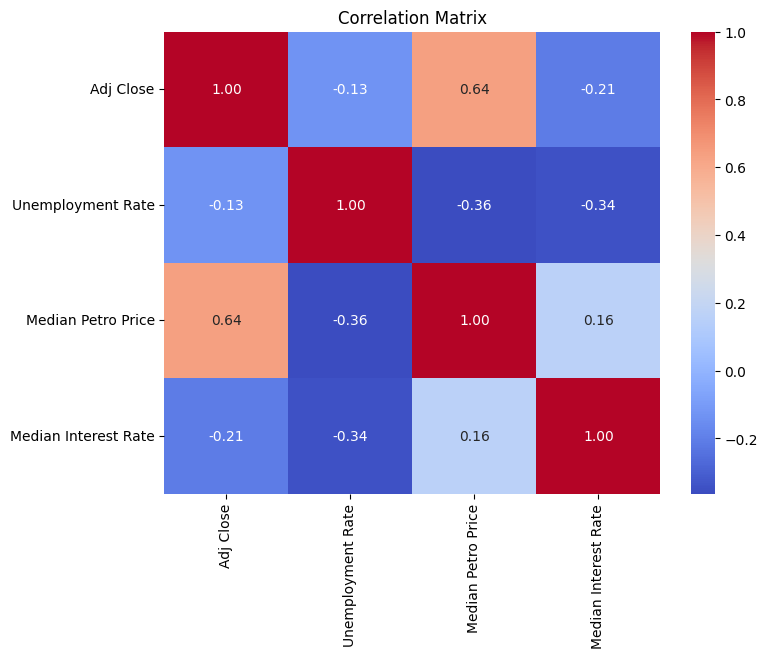

In [22]:
cols = ['Adj Close', 'Unemployment Rate', 'Median Petro Price', 'Median Interest Rate']
correlation_matrix = all_factors[cols].corr()

# Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Based on the heatmap, petroleum prices show the highest correlation with Tesla's stock price, which aligns with expectations. As gasoline-powered cars and electric vehicles are competing products, an increase in fuel prices raises the cost of owning traditional cars, pushing more consumers toward electric vehicles, where Tesla is a market leader.

On the other hand, interest rates have a weaker correlation with Tesla's stock price. Unlike real estate, electric vehicles, while sometimes costly, are often affordable enough to be purchased outright or financed over shorter terms. This helps explain the modest negative correlation (-0.21).

Similarly, the unemployment rate shows a low correlation, as Tesla vehicles aren't considered luxury or high-cost items, reducing the broader economic impact on demand.

## 3. Forecasting stock price

#### train test split

In [37]:
# all_factors

In [36]:
tesla = stock_median.set_index('Year_Month')
tesla.index.name = None
# tesla

In [25]:
# train_data
# test_data

No. of training examples: 117
No. of testing examples: 12


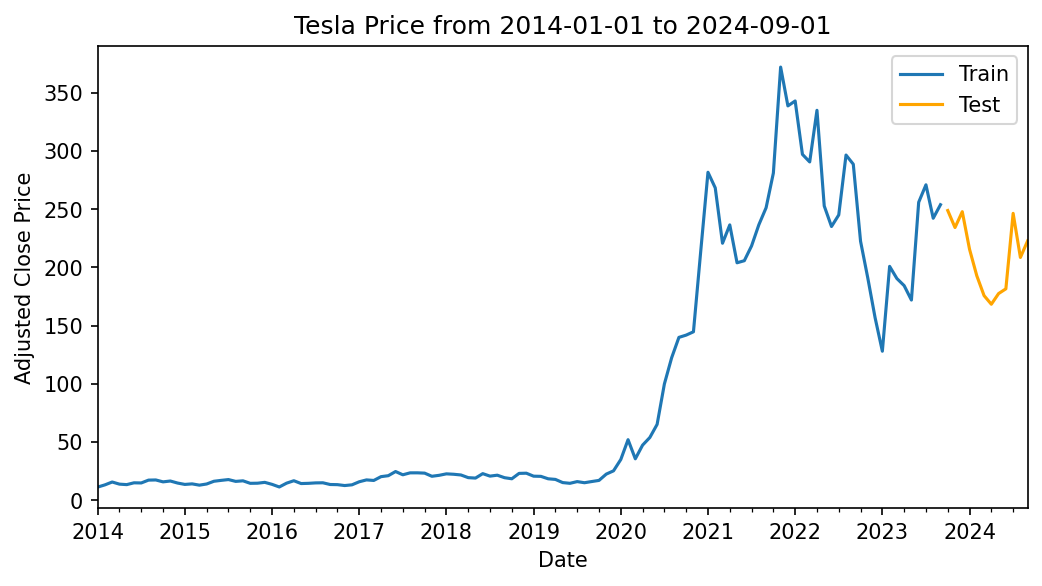

In [26]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Create a test set of 12 data points
test_size = 12

# Ensure that the index of 'tesla' DataFrame is datetime formatted
tesla.index = pd.to_datetime(tesla.index, format='%Y-%m')

train_data, test_data = train_test_split(tesla, test_size=test_size, random_state=25, shuffle=False)

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

# Set the plot size
plt.figure(figsize=(8,4), dpi=150)

train_data['Adj Close'].plot(label='Train')
test_data['Adj Close'].plot(label='Test', color='orange')

# Set the x-axis limits to ensure the test data appears on the right side
plt.xlim(tesla.index.min(), tesla.index.max())

plt.title('Tesla Price from {} to {}'.format(tesla.index.min().strftime('%Y-%m-%d'), tesla.index.max().strftime('%Y-%m-%d')))

plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')

plt.legend()
plt.show()


From the graph, it is evident that stock prices prior to 2019 offer limited predictive value for the stock's performance in 2024. Consequently, I will focus on data from 2019 to 2024 for a more relevant analysis.

In [38]:
# Filter the data for the period between 2019-09 and 2024-09
tesla_five_yrs = tesla.loc['2019-09':'2024-09']
tesla_five_yrs

,Adj Close
2019-09,16.070001
2019-10,17.038668
2019-11,22.449333
2019-12,25.266001
2020-01,34.990665
...,...
2024-05,177.505005
2024-06,181.570007
2024-07,246.385002
2024-08,208.520004


No. of training examples: 49
No. of testing examples: 12


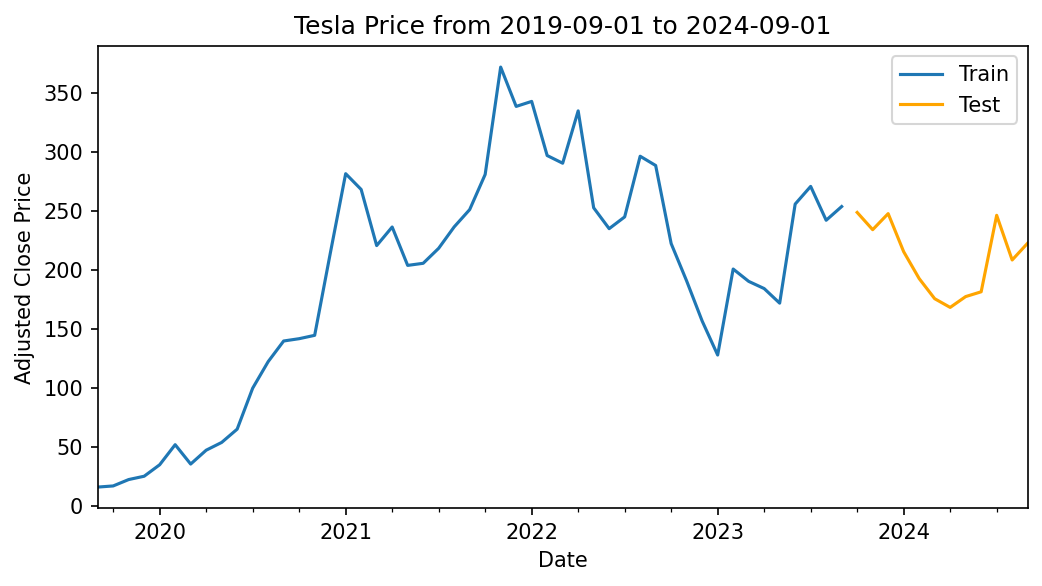

In [39]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Create a test set of 12 data points
test_size = 12

# Ensure that the index of 'tesla' DataFrame is datetime formatted
tesla_five_yrs.index = pd.to_datetime(tesla_five_yrs.index, format='%Y-%m')

train_data, test_data = train_test_split(tesla_five_yrs, test_size=test_size, random_state=25, shuffle=False)

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

# Set the plot size
plt.figure(figsize=(8,4), dpi=150)

train_data['Adj Close'].plot(label='Train')
test_data['Adj Close'].plot(label='Test', color='orange')

# Set the x-axis limits to ensure the test data appears on the right side
plt.xlim(tesla_five_yrs.index.min(), tesla_five_yrs.index.max())

plt.title('Tesla Price from {} to {}'.format(tesla_five_yrs.index.min().strftime('%Y-%m-%d'), tesla_five_yrs.index.max().strftime('%Y-%m-%d')))

plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')

plt.legend()
plt.show()


#### ETS models

##### Simple

In [56]:
#First Instance
ins1 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.2,optimized=False)
ins_cast1 = ins1.forecast(12).rename('alpha=0.2')

#Second Instance
ins2 = SimpleExpSmoothing(train_data).fit(smoothing_level=0.5,optimized=False)
ins_cast2 = ins2.forecast(12).rename('alpha=0.5')

#Third Instance
ins3 = SimpleExpSmoothing(train_data).fit()
ins_cast3 = ins3.forecast(12).rename('alpha=%s'%ins3.model.params['smoothing_level'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


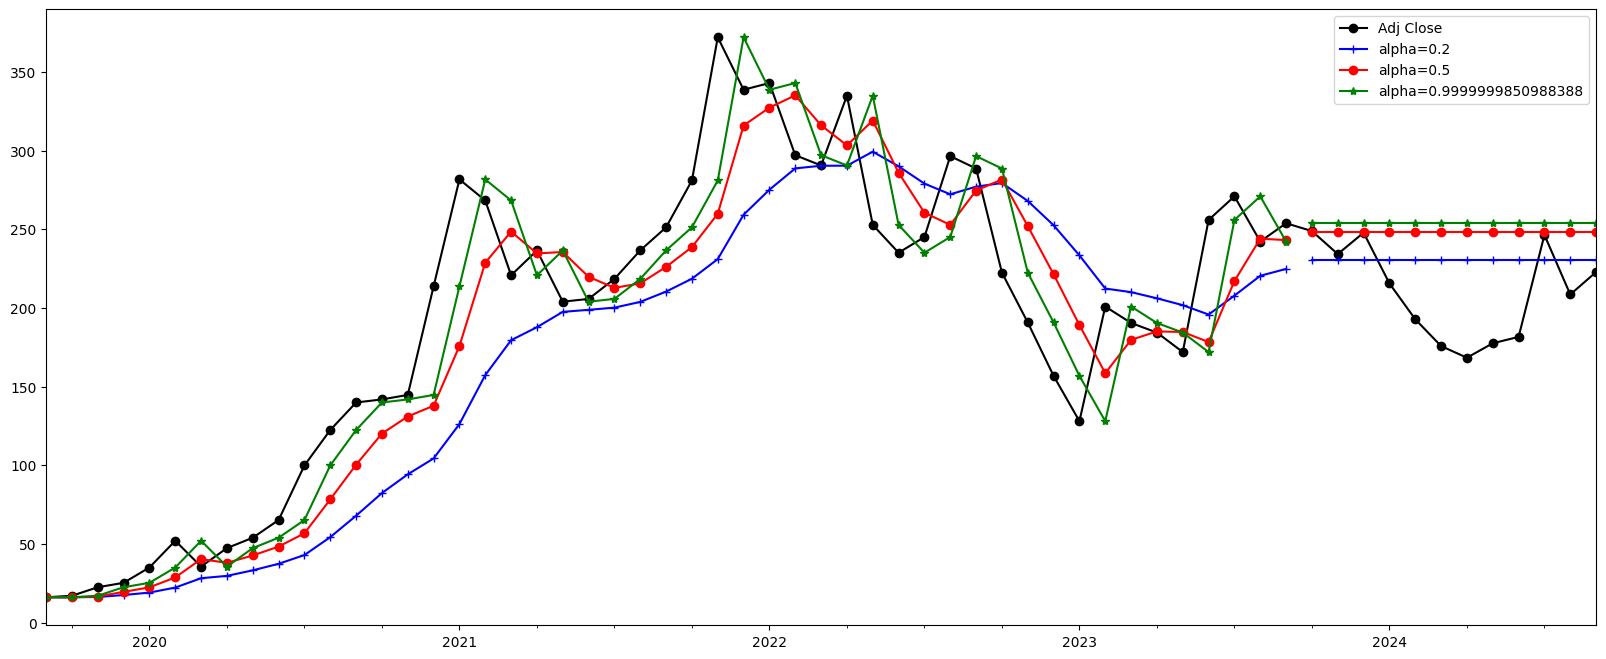

In [58]:
#After creating model we will visualize the plot
ax = tesla_five_yrs.plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for alpha =0.2
ins_cast1.plot(marker='+', ax=ax, color='blue', legend=True)
ins1.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for alpha = 0.5
ins_cast2.plot(marker='o', ax=ax, color='red', legend=True)
ins2.fittedvalues.plot(marker='o', ax=ax, color='red')

#Plot for alpha=Optimized by statsmodel
ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
ins3.fittedvalues.plot(marker='*', ax=ax, color='green')

plt.show()

##### Double

In [59]:
double_ets_add = ExponentialSmoothing(train_data, trend = 'add').fit()
double_ets_mul = ExponentialSmoothing(train_data, trend = 'mul').fit()

double_ets_add_pred = double_ets_add.forecast(12)
double_ets_mul_pred = double_ets_mul.forecast(12)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


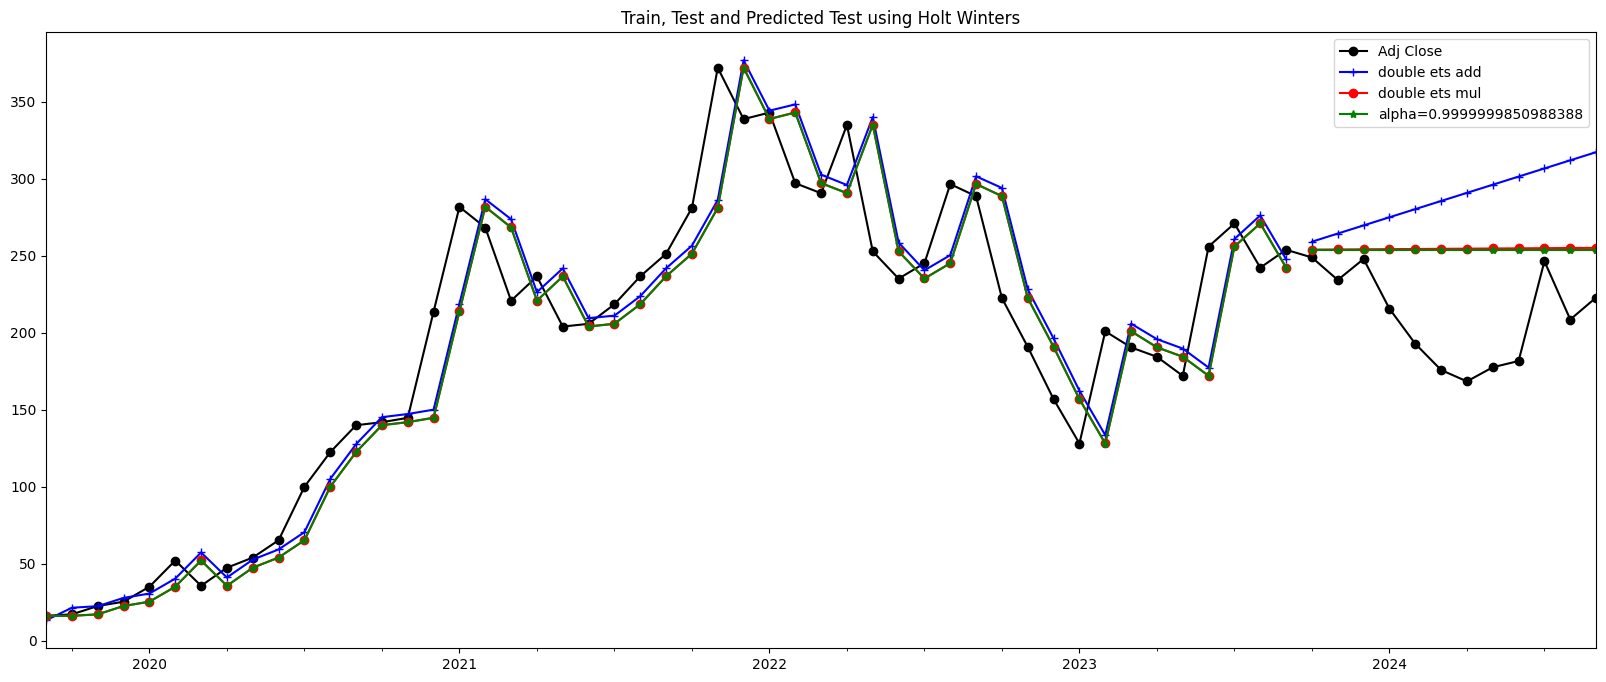

In [60]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
ax = tesla_five_yrs.plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for double ETS additive
double_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'double ets add')
double_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for double ETS multiplicative
double_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'double ets mul')
double_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

#Plot for simple exponential smooting alpha=Optimized by statsmodel
ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
ins3.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()

##### Triple

In [61]:
# triple ETS - Holt Winter's Seasonal Method
triple_ets_add = ExponentialSmoothing(train_data, trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul = ExponentialSmoothing(train_data, trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()

triple_ets_add_pred = triple_ets_add.forecast(12)
triple_ets_mul_pred = triple_ets_mul.forecast(12)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


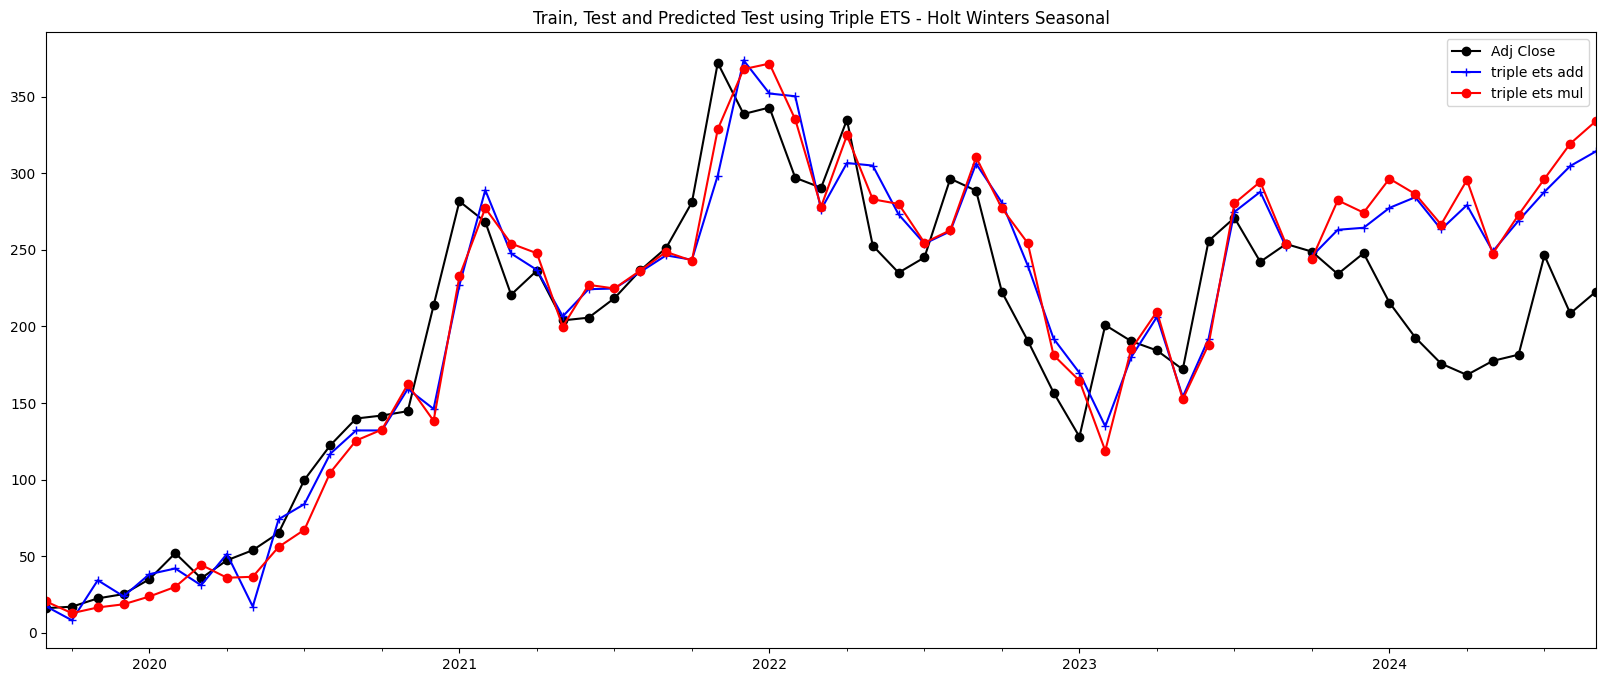

In [63]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
ax = tesla_five_yrs.plot(marker='o', color='black', figsize=(20,8), legend=True)

#Plot for double ETS additive
triple_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'triple ets add')
triple_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for double ETS multiplicative
triple_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'triple ets mul')
triple_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

#Plot for simple exponential smooting alpha=Optimized by statsmodel
#ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
#ins3.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.title('Train, Test and Predicted Test using Triple ETS - Holt Winters Seasonal')
plt.show()

#### Evaluation

 Accuracy metrics: \
 RMSE (Root Mean Squared Error) \
 MAE (Mean Absolute Error) \
 MAPE (Mean Absolute Percentage Error) \
 Cumulative Forecast Error (CFE) \
 R-squared (R^2)

I chose CFE and R² as additional metrics. CFE helps detect any long-term bias in the model, indicating whether it consistently over or under estimates stock prices. This is important for financial forecasting, where small biases can compound over time. R² measures the overall fit of the model to the data, reflecting how well the model explains the variance in stock prices. By combining these with RMSE and MAE, we get a fuller picture of both accuracy and model bias.

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from math import sqrt
import pandas as pd

# Define the metrics dataframe which will be used for storing results
metrics_dataframe = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'MAPE', 'CFE', 'R-squared'])

def metrics_cal(actuals, predictions, model):
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    # Additional metrics
    cfe = np.sum(actuals - predictions)  # Cumulative Forecast Error (CFE)
    r_squared = r2_score(actuals, predictions)  # R-squared (R^2)

    # Store all metrics in the DataFrame
    df = pd.DataFrame({'Model': [model],
                       'RMSE': [rmse],
                       'MAE': [mae],
                       'MAPE': [mape],
                       'CFE': [cfe],
                       'R-squared': [r_squared]})

    global metrics_dataframe
    metrics_dataframe = pd.concat([metrics_dataframe, df], ignore_index=True)
    return metrics_dataframe

In [65]:
#get all the metrics
metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                ins_cast1.values.flatten(),
                                'Simple 0.2')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                ins_cast2.values.flatten(),
                                'Simple 0.5')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                ins_cast3.values.flatten(),
                                'Simple 1')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                double_ets_add_pred.values.flatten(),
                                'Double Add')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                double_ets_mul_pred.values.flatten(),
                                'Double Mul')


metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                triple_ets_add_pred.values.flatten(),
                                'Triple Add')

metrics_dataframe = metrics_cal(test_data.values.flatten(),
                                triple_ets_mul_pred.values.flatten(),
                                'Triple Mul')

<ipython-input-64-49912cf40948>:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, df], ignore_index=True)


In [68]:
metrics_dataframe.sort_values(by='MAE')

,Model,RMSE,MAE,MAPE,CFE,R-squared
0,Simple 0.2,35.587684,29.731948,15.666495,-246.960142,-0.502448
1,Simple 0.5,48.182107,38.514374,20.660883,-461.425996,-1.754049
2,Simple 1,52.557574,43.810412,23.237581,-525.724943,-2.276957
4,Double Mul,53.186980,44.488797,23.573921,-533.865560,-2.355913
5,Triple Add,73.835440,65.710734,33.720864,-782.638024,-5.467401
6,Triple Mul,83.271763,75.439065,38.300055,-896.033584,-7.226130
3,Double Add,87.244380,78.135133,40.256179,-937.621600,-8.029735


According to the metrics, the Simple 0.2 model is the best for predicting Tesla's stock price. It has the lowest values for RMSE (35.59), MAE (29.73), and MAPE (15.67%), which means it minimizes both large and average prediction errors. Additionally, the model’s CFE of -246.96 indicates the least bias compared to other models. While its R² is negative, at -0.50, it is still better than more complex models like Double Add and Triple Mul, showing that higher smoothing factors lead to worse fits. Therefore, Simple 0.2 appears as the best balance between minimizing errors and avoiding significant bias, making it the most reliable for forecasting Tesla stock prices.